In [36]:
import torch 
import os
import numpy as np
import umap
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from FeatureExtraction.PreTrainedBased import main 
from models.main import DeepSets

from torch.utils.data import Dataset, DataLoader

## define parameters of the epxeriments

In [2]:
current_dir = os.getcwd()
data_path = os.path.join(current_dir, "data")
annotation_path = os.path.join(data_path, "clinical_annotation.csv")
trainset_path = os.path.join(data_path, "trainset")

In [3]:
df_resnet_train = pd.read_csv("./data/resent50train.csv", index_col='Unnamed: 0')
df_resnet_test = pd.read_csv("./data/resent50test.csv", index_col='Unnamed: 0')

## Read annotation CSV file

In [4]:
# load data 
df_ann = pd.read_csv(annotation_path)
df_ann.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# compute age 
def compute_age(x):
    year = int(x[-4:])
    return 2024 - year
    
df_ann["age"] = df_ann.DOB.apply(compute_age)

#encode gender
df_ann["GENDER"] = df_ann["GENDER"].replace('f', "F")
label_encoder = LabelEncoder()
df_ann['GENDER'] = label_encoder.fit_transform(df_ann['GENDER'])

df_ann.set_index("ID", inplace=True)

In [6]:
df_ann_ = df_ann.drop("DOB", axis=1)

In [7]:
df_ann_sub = df_ann_.loc[df_ann.LABEL==-1.]
"""df_ann_train, df_ann_test = train_test_split(df_ann_.loc[df_ann.LABEL>=0], 
                                             test_size=0.2, 
                                             stratify=df_ann_.loc[df_ann.LABEL>=0].LABEL)"""
df_ann_train = df_ann_.loc[df_ann_.index.isin(df_resnet_train.ID)]
df_ann_test = df_ann_.loc[df_ann_.index.isin(df_resnet_test.ID)]

In [8]:
print("Submission set: ", df_ann_sub.shape[0])
print("Train set: ", df_ann_train.shape[0])
print("Test set: ", df_ann_test.shape[0])

Submission set:  42
Train set:  130
Test set:  33


## Tabular data 

In [9]:
df_ann_train.head()

,LABEL,GENDER,LYMPH_COUNT,age
ID,,,,
P89,1,1,9.6,89
P61,1,0,11.6,93
P112,1,0,22.1,78
P184,1,0,220.0,92
P23,1,1,211.0,82


In [10]:
y_train = df_ann_train.LABEL
X_train = df_ann_train.drop("LABEL", axis=1)

y_test = df_ann_test.LABEL
X_test = df_ann_test.drop("LABEL", axis=1)

In [11]:
# Initialize Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [12]:
# Make predictions
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9090909090909091


Performance is ok without images.

## Images

In [13]:
# dico_train = main(trainset_path, img_size=224, patients=df_ann_train.index)

In [15]:
dico_train = main(data_path=trainset_path, img_size=224, patients=df_ann_train.index)

In [16]:
all_df = pd.DataFrame(columns=list(np.arange(2048))+["ID"])

for key in dico_train.keys():
    df = pd.DataFrame(np.array(dico_train[key]), columns=list(np.arange(2048)))
    df["ID"] = key
    all_df = pd.concat([all_df, df], ignore_index=True)

In [17]:
all_df.shape

(10790, 2049)

In [18]:
all_df.to_csv("./data/resnet50train.csv")

In [23]:
all_df = all_df.join(df_ann_train.LABEL, on="ID")

In [30]:
scaler = StandardScaler()
all_df_scaled = pd.DataFrame(scaler.fit_transform(all_df[list(np.arange(2048))]), columns=np.arange(2048))

In [31]:
points = all_df_scaled[list(np.arange(2048))].to_numpy()

# Initialize UMAP with desired parameters
umap_model = umap.UMAP()

# Fit UMAP to your data and transform it to 2D
umap_result = umap_model.fit_transform(points)

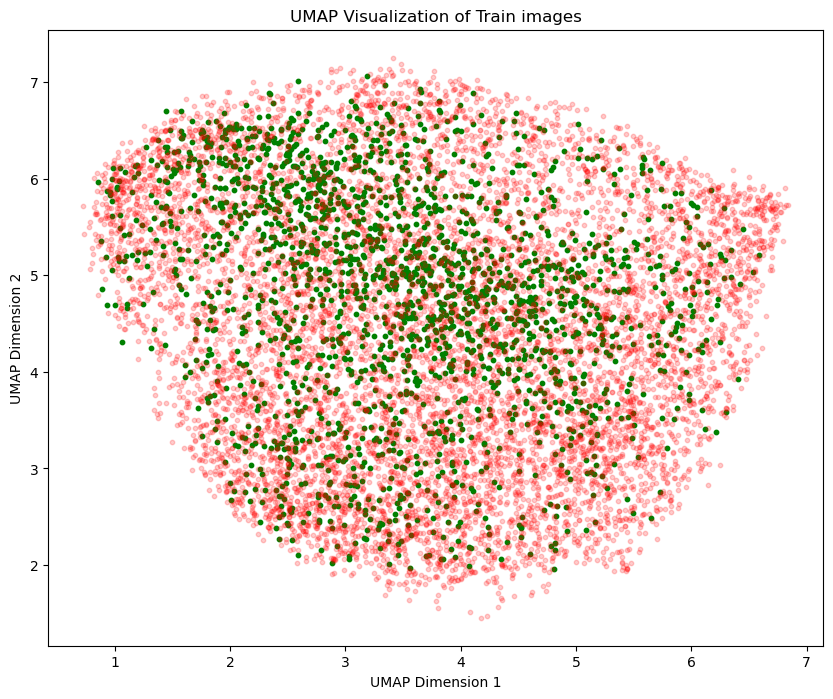

In [32]:
plt.figure(figsize=(10, 8))

plt.scatter(umap_result[all_df.loc[all_df.LABEL==0].index, 0], 
            umap_result[all_df.loc[all_df.LABEL==0].index, 1], 
            marker='o', s=10, color="green")

plt.scatter(umap_result[all_df.loc[all_df.LABEL==1].index, 0], 
            umap_result[all_df.loc[all_df.LABEL==1].index, 1], 
            marker='o', s=10, color="red", alpha=0.2)

plt.title('UMAP Visualization of Train images')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [37]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
        # Extract unique IDs
        self.ids = dataframe['id'].unique()
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_val = self.ids[idx]
        features = self.dataframe.loc[self.dataframe['id'] == id_val].drop(columns=['id']).values
        
        return torch.tensor(features, dtype=torch.float32)

In [44]:
ids = pd.unique(all_df.ID)
data = [(all_df[np.arange(2048)].loc[all_df.ID == id].to_numpy(), all_df.loc[all_df.ID == id].LABEL.sum() > 0) for id in ids]

In [46]:
train_loader = DataLoader(data)

In [47]:
for batch in train_loader:
    print(batch)

[tensor([[[0.3775, 0.5766, 0.4560,  ..., 0.3217, 0.4369, 0.3450],
         [0.3661, 0.5458, 0.3978,  ..., 0.3389, 0.4231, 0.3285],
         [0.3920, 0.5756, 0.4656,  ..., 0.3159, 0.4815, 0.3705],
         ...,
         [0.3642, 0.5483, 0.4483,  ..., 0.3204, 0.4364, 0.3260],
         [0.3922, 0.5664, 0.4983,  ..., 0.2964, 0.4259, 0.3135],
         [0.3590, 0.5592, 0.4337,  ..., 0.3541, 0.4424, 0.3316]]]), tensor([True])]
[tensor([[[0.3611, 0.5388, 0.4600,  ..., 0.3422, 0.4949, 0.3599],
         [0.3383, 0.4754, 0.4992,  ..., 0.3481, 0.4205, 0.3493],
         [0.3775, 0.5803, 0.5176,  ..., 0.3079, 0.4612, 0.3595],
         ...,
         [0.3475, 0.5606, 0.4650,  ..., 0.3482, 0.4301, 0.3331],
         [0.4062, 0.5903, 0.4907,  ..., 0.3682, 0.4508, 0.3870],
         [0.4027, 0.4889, 0.4743,  ..., 0.3627, 0.4566, 0.3734]]]), tensor([True])]
[tensor([[[0.3698, 0.5518, 0.4454,  ..., 0.3095, 0.4606, 0.3491],
         [0.3586, 0.5809, 0.4596,  ..., 0.3303, 0.4702, 0.3349],
         [0.3867, 0.4

In [50]:
# download data
df = pd.read_csv("./data/resnet50train.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df_test = pd.read_csv("./data/resnet50test.csv")
df_test.drop('Unnamed: 0', axis=1, inplace=True)

df_ann = pd.read_csv("./data/clinical_annotation.csv")
df_ann.set_index("ID", inplace=True)

# join datasets 
df = df.join(df_ann.LABEL, on="ID", how="left")
df_test = df_test.join(df_ann.LABEL, on="ID", how="left")


In [51]:
    # scaling 
    col = [str(i) for i in range(2048)]
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[col]), columns=col)
    df_test_scaled = pd.DataFrame(scaler.transform(df[col]), columns=col)

    df_scaled["ID"] = df.ID
    df_scaled["LABEL"] = df.LABEL
    df_test_scaled["ID"] = df_test.ID
    df_test_scaled["LABEL"] = df_test.LABEL

In [58]:
def deepsets_loader(df):
    """
    
    """
    ids = pd.unique(df.ID)

    col = [str(i) for i in range(2048)]
    data = [(df[col].loc[df.ID == id].to_numpy(), df.loc[df.ID == id].LABEL.sum() > 0) for id in ids]
    data = [(torch.tensor(x, dtype=torch.float32), torch.tensor([y], dtype=torch.float32)) for x, y in data]
    train_loader = DataLoader(data, shuffle=False)

    return train_loader

In [66]:
train_loader = deepsets_loader(df_test_scaled)

In [67]:
dataset = train_loader.dataset

In [77]:
for i, d in enumerate(dataset):

    if len(d[0])==0:
        print(i)
        print(d)

print(len(dataset))

33
(tensor([], size=(0, 2048)), tensor([0.]))
34


In [81]:
"""df_test_scaled[df_test_scaled.index == list(pd.unique(df_test_scaled.ID))[33]]"""
len(pd.unique(df_test.ID)), len(pd.unique(df_test_scaled.ID))

(33, 34)

In [82]:
len(df_test.ID), len(df_test_scaled.ID)

(2663, 10790)